In [23]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import os

### Data Source: https://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [24]:

# Leemos el dataset

df = pd.read_csv('data/auto-mpg.data',  header=None)

df[[0, 'car_name']] = df[0].str.split('\t', expand=True)

df.head()


,0,car_name
0,18.0 8 307.0 130.0 3504. 12...,"""chevrolet chevelle malibu"""
1,15.0 8 350.0 165.0 3693. 11...,"""buick skylark 320"""
2,18.0 8 318.0 150.0 3436. 11...,"""plymouth satellite"""
3,16.0 8 304.0 150.0 3433. 12...,"""amc rebel sst"""
4,17.0 8 302.0 140.0 3449. 10...,"""ford torino"""


In [25]:

# Definimos el nombre de las columnas
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']

# Alistamos el dataframe
df[columns] = df[0].str.split(expand=True)
df.drop(columns=[0], inplace=True)
df['car_name'] = df['car_name'].apply(lambda x: x.replace('"', ''))

df.head()

,car_name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.,12.0,70,1
1,buick skylark 320,15.0,8,350.0,165.0,3693.,11.5,70,1
2,plymouth satellite,18.0,8,318.0,150.0,3436.,11.0,70,1
3,amc rebel sst,16.0,8,304.0,150.0,3433.,12.0,70,1
4,ford torino,17.0,8,302.0,140.0,3449.,10.5,70,1


In [26]:
# convertimos las columnas a float 
for col in df.columns:
    if col not in ['mpg', 'car_name']:
        df = df[pd.to_numeric(df[col], errors='coerce').notnull()]
        df[col] = df[col].astype(float)

# separando variables dependientes e independientes
X = df[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']]
y = df['mpg']

In [27]:
# train test split
train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

In [28]:
# función para evaluar el rendimiento del modelo
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    return rmse, mae

## La forma convencional

In [29]:
alpha, l1_ratio = 0.01, 0.15
    
# Iniciamos el modelo elastic
lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

# Entrenamos el modelos con los datos de entrenamiento
lr.fit(train_X, train_y)

# Hacemos las predicciones con el connjunto de prueba
y_pred = lr.predict(test_X)

# obteniendo el rendimiento del modelo
rmse, mae = eval_metrics(test_y, y_pred)

print('Hyperparameters: Alpha =  {}, L1 Ratio = {} \n'.format(alpha, l1_ratio))

print('Rendimiento del modelo en el conjunto de prueba: RMSE = {}, MAE = {} \n'.format(rmse, mae))

Hyperparameters: Alpha =  0.01, L1 Ratio = 0.15 

Model Performance on test set: RMSE = 3.2640850592427517, MAE = 2.442825267353494 



In [30]:
alphas, l1_ratios = [0.01, 0.02, 0.5], [0.15, 0.2, 0.5]
    
for alpha in alphas:
    for l1_ratio in l1_ratios:
        # Iniciamos el modelo elastic net
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

        # Hacemos las predicciones con el conjunto de datos de entrenamiento
        lr.fit(train_X, train_y)

        # Hacemos las predicciones con el conjunto de prueba
        y_pred = lr.predict(test_X)

        # obteniendo el rendimiento del modelo
        rmse, mae = eval_metrics(test_y, y_pred)

        print('Hyperparameters: Alpha =  {}, L1 Ratio = {} \n'.format(alpha, l1_ratio))

        print('Rendimiento del modelo en el conjunto de prueba: RMSE = {}, MAE = {} \n'.format(rmse, mae))
        
        print ('-'*50,'\n')

Hyperparameters: Alpha =  0.01, L1 Ratio = 0.15 

Model Performance on test set: RMSE = 3.2640850592427517, MAE = 2.442825267353494 

-------------------------------------------------- 

Hyperparameters: Alpha =  0.01, L1 Ratio = 0.2 

Model Performance on test set: RMSE = 3.2641081943690287, MAE = 2.442779799335202 

-------------------------------------------------- 

Hyperparameters: Alpha =  0.01, L1 Ratio = 0.5 

Model Performance on test set: RMSE = 3.2642539363043768, MAE = 2.4425053728576818 

-------------------------------------------------- 

Hyperparameters: Alpha =  0.02, L1 Ratio = 0.15 

Model Performance on test set: RMSE = 3.2682306618265713, MAE = 2.446223624638199 

-------------------------------------------------- 

Hyperparameters: Alpha =  0.02, L1 Ratio = 0.2 

Model Performance on test set: RMSE = 3.268290119727703, MAE = 2.446143110178123 

-------------------------------------------------- 

Hyperparameters: Alpha =  0.02, L1 Ratio = 0.5 

Model Performance o

## Usando mlflow

In [31]:
from mlflow.tracking import MlflowClient

In [32]:
# Definimos el nombre de modelos
experiment_name = 'Modelo_Regresión'

# Proporcione uri y conéctese a su servidor de seguimiento
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Inicializar cliente MLflow
client = MlflowClient()

# Si el experimento no existe, creará un nuevo
# de lo contrario, tomará la identificación del experimento y lo usará para ejecutar los experimentos
try:
    # Creamos el experimento
    exp_id  = client.create_experiment(experiment_name)
except:
    # Obtener la identificación del experimento si ya existe
    exp_id  = client.get_experiment_by_name(experiment_name).experiment_id
    


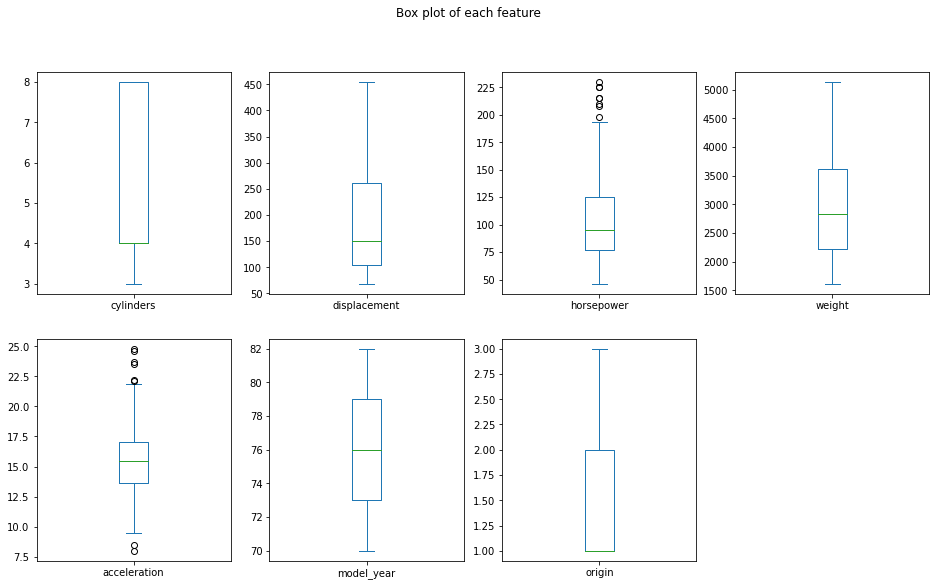

In [36]:
if 'images' not in os.listdir():
    os.mkdir('images')

with mlflow.start_run(experiment_id=exp_id, run_name="ElasticNet") as run:
    
    
    # Obtener identificación de ejecución
    run_id = run.info.run_uuid
        
    # Proporcione notas breves sobre el run.
    MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "Este es un Modelo de Regresión de Machine Learning para predecir el mpg")

    
    # simulación del proceso EDA mediante la creación de gráficos de distribución para todas las características
    train_X.plot(kind='box', subplots=True, layout=(2,4), figsize=(16,9), title='Box plot para cada Variable', size=20)
    
    # guardar la imagen en la carpeta de imágenes
    plt.savefig('images/distribution_plot_all_features.png')

    # logging artifacts -> guarda la imagen y permite el seguimiento para su uso posterior
    mlflow.log_artifacts('images')
    
    # definimos los parametros alpha y l1 ratio
    alpha, l1_ratio = 0.02, 0.15
    
    # Iniciamos el model elastic net
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

    # Entrenamos el modelo con el conjunto de entrenamiento
    lr.fit(train_X, train_y)

    # Hacemos las predicciones con el conjunto de prueba
    y_pred = lr.predict(test_X)

    # Obtenemos la evaluación del modelo
    rmse, mae = eval_metrics(test_y, y_pred)
    
    # logging the parameters 
    mlflow.log_param('alpha', alpha)
    mlflow.log_param('l1_ratio', l1_ratio)
    
    # logging the metrics
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('mae', mae)
    
    # guardar el modelo para su uso posterior
    mlflow.sklearn.log_model(lr, "Regression_Model")
    

## Hyperparameter Tuning using mlflow

In [ ]:
# defining a new experiment
experiment_name = 'PlainRegression_HyperParameter_Search'
# returns experiment ID
try:
    # creating a new experiment
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [ ]:
# defining alpha and l1 ratio
alphas, l1_ratios = [0.01, 0.05, 0.1, 0.02, 0.03], [0.15, 0.1, 0.2, 0.25]

for alpha in alphas:
    for l1_ratio in l1_ratios:
        # starting an mlflow run, and tracking them under the experiment defined above
        with mlflow.start_run(experiment_id=exp_id):

            # logging artifacts -> saves the image and enables tracking for later use
            mlflow.log_artifacts('images')

            # initiating an elastic net model
            lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)

            # fitting the model with train dataset
            lr.fit(train_X, train_y)

            # making predictions on test set
            y_pred = lr.predict(test_X)

            # obtaining the model performance
            rmse, mae = eval_metrics(test_y, y_pred)

            # logging hyperparameters defined above
            mlflow.log_param("alpha", alpha)
            mlflow.log_param("l1_ratio", l1_ratio)

            # logging performance of the model
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("mae", mae)
    